In [1]:
from diffusion_conditional_masked import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
dataset = source_domain_numpy(root="../data", root_list='mnist_m')

In [ ]:
len(dataset)

In [ ]:
# hardcoding these here
#seed = 10
#set_seed(seed)
n_epoch = 1
batch_size = 256
n_T = 400 # 500
device = "cuda:3"
n_classes = 10 + 1
target_domain_index = 1

n_domains = 4
n_feat = 128 # 128 ok, 256 better (but slower)
lrate = 1e-4
save_model = True
save_dir = './data/diffusion_outputs_masked_sameC_temp/'
#save_dir = './data/diffusion_outputs_masked_Apr21_transforms/'
ws_test = [1]
save_gif = False

in_channels = 3 #1
ddpm = DDPM(nn_model=ContextUnet(in_channels=in_channels, n_feat=n_feat, n_classes=n_classes, n_domains=n_domains), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

# optionally load a model
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)
ce_loss_criterion = nn.CrossEntropyLoss()

for ep in [460]:
    ddpm.load_state_dict(torch.load(f"./data/diffusion_outputs_masked_sameC/model_{ep}.pth", map_location=device))
    #ddpm.load_state_dict(torch.load(f"./data/diffusion_outputs_masked/model_99.pth"))

    ddpm.eval()

    with torch.no_grad():
        n_sample = 4 * n_classes*n_domains
        for w_i, w in enumerate(ws_test):
            x_gen, x_gen_store = ddpm.sample(n_sample, (in_channels, 28, 28), device, guide_w=w)

            # append some real images at bottom, order by class also
            x_real = torch.Tensor(x_gen.shape).to(device)
            for k in range(n_classes*n_domains):
                for j in range(int(n_sample/(n_classes*n_domains))):
                    try: 
                        idx = torch.squeeze((d_real_samples*n_classes+c_real_samples == k).nonzero())[j]
                    except:
                        idx = -1
                    x_real[k+(j*(n_classes*n_domains))] = 0 if (idx == -1) else x_real_samples[idx]
            x_all = torch.cat([x_gen, x_real])

    figure(figsize=(13, 10))
    for j in range(4):
        for i in range(10):
            plt.subplot(8, 10,  j*10 + i+1)
            img = x_all[(4*j+1)*11 + i] #.cpu().detach().numpy()
            img = (img*-1)+1
            img = img.detach().cpu().numpy().transpose(1, 2, 0)
            img = (img - img.min())/(img.max() - img.min())

            plt.axis("off")
            plt.imshow(img)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
#ws_test = [0.0, 0.5, 2.0]
batch_size = 32
n_sample = n_classes * batch_size #n_domains
req_size = 55000 #n_sample - batch_size #20000
ddpm.eval()
x_gen_all = []
with torch.no_grad():
    w = 2
    for itr in tqdm(range(int(req_size/(n_sample - batch_size)))):
        x_gen, _ = ddpm.sample_from_one_domain(n_sample, (in_channels, 28, 28), target_domain = 1, device=device, guide_w=2)
        x_gen_all.append(x_gen.detach().cpu().numpy())

In [ ]:
synthetic_images = np.vstack(x_gen_all)
labels = torch.tensor([i for j in range(int(len(synthetic_images)/n_classes)) for i in range(n_classes) ])
synthetic_images_filtered, labels_filtered = synthetic_images[labels != n_classes-1], labels[labels != n_classes-1]

synthetic_images_filtered = synthetic_images_filtered.transpose(0, 2, 3, 1)
synthetic_images_filtered_32 = np.stack(np.array([Image.fromarray((img * 255).astype(np.uint8)).resize(size=(32, 32)) for img in synthetic_images_filtered]))



In [ ]:
save_path = "../data/mnist_m_synthetic_epoch460/MNIST_M_SYNTHETIC_EPOCH460_train.pt"
torch.save([synthetic_images_filtered_32, labels_filtered.cpu().detach().numpy()], save_path)

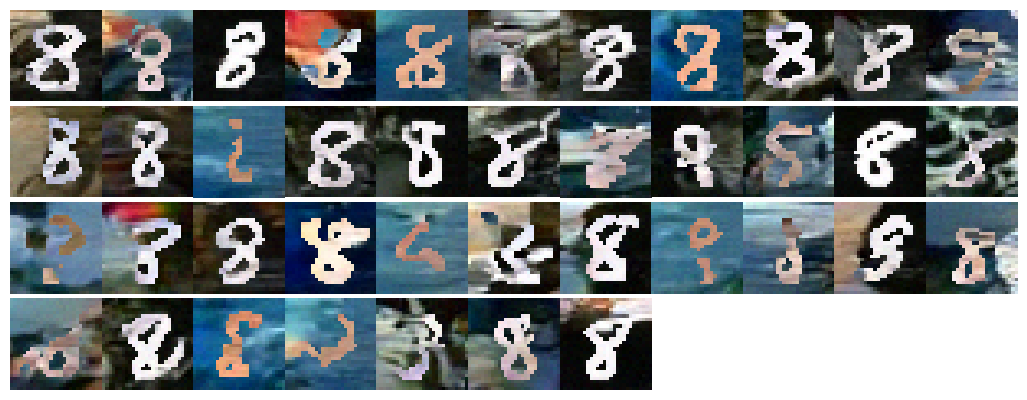

In [25]:
figure(figsize=(13, 10))
for j in range(4):
    for i in range(10):
        plt.subplot(8, 11,  j*10 + i+1)
        
        #img = x_gen[(j)*11 + i] #.cpu().detach().numpy()
        img = np.array(Image.open(f"/home/pdsouzar/Diffusion-Model-Digit-Generation/best_images/{8}_{i * 132 +j +1}.png"))
        #img = (img*-1)+1
        #img = img.detach().cpu().numpy().transpose(1, 2, 0)
        #img = (img - img.min())/(img.max() - img.min())

        plt.axis("off")
        plt.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [5]:
img.shape

(28, 28, 3)

In [ ]:

figure(figsize=(13, 10))
for j in range(4):
    for i in range(10):
        plt.subplot(8, 10,  j*10 + i+1)
        #img = x_all[(4*j+1)*11 + i] #.cpu().detach().numpy()
        #img = (img*-1)+1
        img = np.array(Image.open(f"../../Diffusion-Model-Digit-Generation/output_unconditional/{0}_{j+9}.png"))
        #img = img.detach().cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min())/(img.max() - img.min())

        plt.axis("off")
        plt.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
!pwd

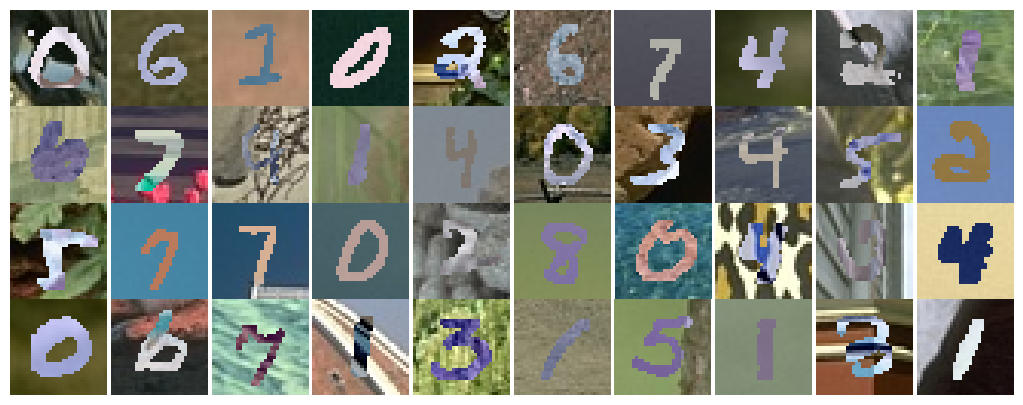

In [19]:
dataset = source_domain_numpy(root="../data", root_list='mnist_m')
figure(figsize=(13, 10))
for j in range(4):
    for i in range(10):
        plt.subplot(8, 10,  j*10 + i+1)
        img = dataset[j*10 + i+900][0] #x_all[(4*j+1)*11 + i] #.cpu().detach().numpy()
        img = np.array(img)
        #img = (img*-1)+1
        #img = img.detach().cpu().numpy().transpose(1, 2, 0)
        #img = (img - img.min())/(img.max() - img.min())

        plt.axis("off")
        plt.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()